# Lecture 16: Matrix functions. Introduction to randomized linear algebra

## Previous lecture

- Large scale eigenvalue problem
- Krylov subspace based methods
- Preconditioned inverse iteration
- LOBPCG
- Jacobi-Davidson method

## Today lecture

- Matrix function
- Matrix exponential and rational Krylov subspaces
- Randomized numerical linear algebra

## Outline of this part

- What is a matrix function
- Matrix exponential
- (Some) applications

Book to read: [Functions of matrices by Nick Higham](http://www.google.ru/books?hl=ru&lr=&id=2Wz_zVUEwPkC&oi=fnd&pg=PR3&dq=Higham+matrix+function&ots=pTt6fpLGRX&sig=DgUuX-SpBZGin8CFUo-4MYnOcHE&redir_esc=y#v=onepage&q=Higham%20matrix%20function&f=false)

## The simplest matrix function: matrix polynomial

It is very easy to define a matrix polynomial as  

$$ P(A) = \sum_{k=0}^n c_k A^k. $$

**Side-note:** [Hamilton-Cayley theorem](https://en.wikipedia.org/wiki/Cayley%E2%80%93Hamilton_theorem) states that $F(A) = 0$ where $F(\lambda) = \det(A - \lambda I)$, thus all matrix polynomials have degree $\leq n-1$.

## Matrix polynomials as building blocks
We can define a function of the matrix by **Taylor series**:  

$$ f(A) = \sum_{k=0}^{\infty} c_k A^k. $$

The convergence is understood as the convergence in some **matrix norm**.  

Example of such series is the **Neumann series**  

$$ (I - F)^{-1} = \sum_{k=0}^{\infty} F^k, $$

which is well defined for $\rho(F) < 1$.

## Matrix exponential series
The most well-known matrix function is **matrix exponential**. In the scalar case,  

$$ e^x = 1 + x + \frac{x^2}{2} + \frac{x^3}{6} + \ldots = \sum_{k=0}^{\infty} \frac{x^k}{k!}, $$

and it directly translates to the matrix case:  

$$ e^A = \sum_{k=0}^{\infty} \frac{A^k}{k!}, $$

the series that always converges, because the series

$$\sum_{k=0}^{\infty} \frac{\Vert A \Vert^k}{k!} = e^{\Vert A \Vert}.$$

## Why matrix exponential is important

A **lot of** practical problems are reduced to a system of linear ODEs of the form  

$$ \frac{dy}{dt} = Ay, \quad y(0) = y_0. $$


## ODE and matrix exponentials

- Given the equation 

$$\frac{dy}{dt} = Ay, \quad y(0) = y_0$$

- The formal solution is given by $y(t) = e^{At} y_0$, so if we know  $e^{At}$ (or can compute matrix-by-vector product fast) there is a big gain over the time-stepping schemes.

- Indeed,

$$\frac{d}{dt} e^{At} = \frac{d}{dt} \sum_{k=0}^{\infty} \frac{t^k A^k}{k!} = \sum_{k=1}^{\infty} \frac{t^{k-1} A^{k}}{(k-1)!}  = A e^{At}.$$

## Sidenote: matrix exponential and time stepping

Matrix exponential can be much better than solving using, say, Euler scheme:

$$\frac{dy}{dt} \approx \frac{y_{k+1} - y_k}{\tau} = A y_k, \quad y_{k+1} = y_k + \tau A y_k,$$

if we know how to compute the product of the matrix exponential by vector using only matrix-by-vector product.

For dense matrices matrix exponential also provides **exact** answer to the ODE for any $t$, compared to the **approximation** by time-stepping schemes.

## How to compute matrix functions, including exponential?

- There are many ways, even for the matrix exponential!

- See [C. Van Loan, C. Moler, Nineteen Dubious Ways to Compute the Exponential of a Matrix, Twenty-Five Years Later](http://www.cs.cornell.edu/cv/researchpdf/19ways+.pdf)

- The simplest way is to diagonalize the matrix:  

$$ A = S \Lambda S^{-1}, $$

where the columns of $S$ are **eigenvectors** of the matrix $A$,  then  

$$ F(A) = S F(\Lambda) S^{-1}. $$

**Problem: diagonalization can be unstable!** (and not every matrix is diagonalizable)

Let us look how matrices are diagonalizable:

In [24]:
import numpy as np
eps = 0
p = 5
a = np.eye(p)
for i in range(p-1):
    a[i, i+1] = 1
    
a[p-1, 2] = eps

print(a)
val, vec = np.linalg.eig(a)
print(val)
print(vec)
print(np.linalg.norm(a - vec @ np.diag(val) @ np.linalg.inv(vec)))
print(vec.dot(val[:, np.newaxis] * np.linalg.inv(vec)))


[[1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]
[1. 1. 1. 1. 1.]
[[ 1.00000000e+00 -1.00000000e+00  1.00000000e+00 -1.00000000e+00
   1.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16 -2.22044605e-16  2.22044605e-16
  -2.22044605e-16]
 [ 0.00000000e+00  0.00000000e+00  4.93038066e-32 -4.93038066e-32
   4.93038066e-32]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.09476443e-47
  -1.09476443e-47]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.43086534e-63]]
2.0
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


Now we can compute a function for **perturbed Jordan block.**

In [25]:
import numpy as np
eps = 1e-16
p = 5
a = np.eye(p)
for i in range(p-1):
    a[i, i+1] = 1
    
a[p-1, 0] = eps
a = np.array(a)
val, vec = np.linalg.eig(a)
print(np.linalg.norm(a - vec.dot(np.diag(val)).dot(np.linalg.inv(vec))))

fun = lambda x: np.exp(x)

#Using diagonalization
fun_diag = vec.dot(np.diag(fun(val))).dot(np.linalg.inv(vec))


#Using Schur
import scipy.linalg
fun_m = scipy.linalg.expm(a)
print('Difference = {}'.format(np.linalg.norm(fun_m - fun_diag)))

2.0
Difference = 5.959978842992802


## How ```funm``` function works

- The exponential of a matrix is a special function, so there are special methods for its computation.  

- For a general function $F$,  there is a beautiful **Schur-Parlett algorithm**, which is based on the **Schur theorem**

## Schur-Parlett algorithm

- Given a matrix $A$ we want to compute $F(A)$, and we only can evaluate $F$ at **scalar points**.  
- First, we reduce $A$ to the **triangular form** as  

$$ A = U T U^*. $$

- Therefore,  $F(A)=U F(T) U^*$

- We only need to compute the function of triangular matrices.

## Computing functions of triangular matrices
We know values on the diagonals

$$ F_{ii} = F(T_{ii}), $$

and also we know that

$$ F T = T F $$

the matrix function commutes with the matrix itself. The function of a triangular matrix is a triangular matrix as well.
Using the known values on the diagonal and the commutativity property, we get the diagonals of the matrix one-by-one:


$$f_{ij} = t_{ij} \frac{f_{ii} - f_{jj}}{t_{ii} - t_{jj}} + \sum_{k=i+1}^{j-1} \frac{f_{ik} t_{kj} - t_{ik}f_{kj}}{t_{ii} - t_{jj}}.$$

## Matrix functions: definition

- One way to define a matrix function $f(A)$ is to use **Jordan canonical form**.

- A much more elegant way is to use **Cauchy integral representation:**

$$
    f(A) = \int_{\Gamma} f(z) (zI - A)^{-1} dz,
$$

where $f(z)$ is analytic on and inside a closed contour $\Gamma$ that encloses the spectrum of $A$.

- This definition can be generalized to the **operator case.**

## Important matrix functions

- Matrix exponential, used to solve $\frac{dy}{dt} = Ay$ in the "explicit" way, $y = e^{At}y_0.$
- $\cos(A), \sin(A)$ used to solve wave equation $\frac{d^2 y}{dt^2} + Ay = 0.$
- Sign function, $\mathrm{sign}(A)$, used to compute **spectral projections.**
- Inverse square root $A^{-1/2}$ used in many places, for example, to generate samples from a Gaussian distributions

## Matrix exponential

- The matrix exponential is given by the following series:

$$e^A = I + A + \frac{1}{2} A^2 + \frac{1}{3!} A^3 + \ldots$$

- This series is a bad idea (even for a scalar case, can you guess why?)

- This form for $e^A$ almost assumes a **Krylov method** for the evaluation of $e^{At} y_0,$ by the way.

In [26]:
import numpy as np

x = -30.0 #Point
k = 1000000 #Number of terms
b = 1.0
x0 = x
for i in range(1, k):
    b += x0
    x0 *= x/(i+1)
    
print('Error in the exponent: {}'.format((b - np.exp(x))/np.exp(x)))

Error in the exponent: 65220007.32064143


## Series convergence

- The series convergence for the matrix exponential can be slow for large $x!$ (and slow for big norm).

- What we can do?

## Method 1: Krylov method

- We can use the idea of Krylov method: using the Arnoldi method, generate the orthogonal basis in the Krylov subspace, and compute (it can be used in general for any function)

$$ f(A)v \approx f(Q H Q^*)v = Q f(H) Q^*v,$$

where $H$ is a small upper Hessenberg matrix, for which we can use, for example, the **Schur-Parlett algorithm.**

- The convergence of the Krylov method can be quite slow: it is actually a **polynomial approximation** to a function.

- And convergence of polynomial approximation to the matrix function **can be slow.**

- **Idea:** Replace by rational approximation!

## Pade approximations

- Matrix exponential is well approximated by **rational function**:  

$$
\exp(x) \approx \frac{p(x)}{q(x)},
$$

where $p(x)$ and $q(x)$ are polynomials and computation of a rational function of a matrix is reduced to **matrix-matrix products** and **matrix inversions**.  

- The rational form is also very useful when only a product of a matrix exponential by vector is needed, since evaluation reduces to **matrix-by-vector products** and **linear systems solvers**

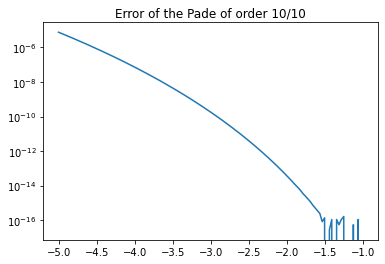

In [27]:
#Computing Pade approximant
import numpy as np
import mpmath
%matplotlib inline
from mpmath import pade, taylor, polyval
import matplotlib.pyplot as plt
x = np.linspace(-5, -1, 128)
a = taylor(mpmath.exp, 0, 20) #Taylor series
k1 = 10
k2 = 10
p, q = pade(a, k1, k2) #Pade approximant
#plt.plot(x, polyval(p[::-1], x)/polyval(q[::-1], x) - np.exp(x))
plt.semilogy(x, polyval(a[::-1], x) - np.exp(x))

_ = plt.title('Error of the Pade of order {0:d}/{1:d}'.format(k1, k2) )

## Scaling & squaring algorithm

The "canonical algorithm" for the computation of the matrix exponential also relies on **scaling** of the matrix $A:$

$$\exp(A) = \exp(A/2^k)^{(2^k)}.$$

The matrix then can have a small norm, thus:

- Scale the matrix as $B := A/2^k$ to make it norm less than $1$.
- Compute exponent of $C = e^B$ by a **Pade approximant**
- Square $e^A \approx C^{(2^k)}$ in $k$ matrix-by-matrix products.

## Large-scale matrix exponentials

- Large-scale matrices obviously do not allow for efficient scaling-and-squaring (need to work with dense matrices), thus we can use **Krylov methods** or (better) Rational Krylov methods.

- The idea of a rational Krylov subspace is motivated by the idea of rational approximation instead of polynomial approximation.

- Krylov methods rely on polynomial approximations

## Rational Krylov subspaces

The simplest (yet efficient) approach is based on the so-called **extended Krylov subspaces:**

$$KE(A, b) = \mathrm{Span}(\ldots, A^{-2} b, A^{-1} b, b, A b, A^2 b, \ldots)$$

At each step you add a vector of the form $A w$ and $A^{-1} w$ to the subspace, and orthogonalize the result (**rational Arnoldi method**).

I.e., we need only linear system solver for one step, but since the matrix $A$ is fixed, we can **factorize it** once

## Rational Krylov methods

Rational Krylov methods are the most efficient for the computation of matrix functions:

- we construct an orthogonal basis in the span,

$$KE(A, b) = \mathrm{Span}(\ldots, A^{-2} b, A^{-1} b, b, A b, A^2 b, \ldots)$$

- compute

$$f(A)b \approx Q f(H) Q^*b,$$

where $H = Q^* A Q.$

It requires one solver and matrix-by-vector product at each step.

## Inverse square root of the matrix

- The inverse square root of the matrix, $A^{-1/2}$ is also often important.

- For example, the multidimensional Gaussian distribution with covariance matrix $A = A^* > 0$ is given by the 

$$e^{A^{-1} x, x}.$$

- Suppose $x$ is really huge (millions), how we **generate samples**, given a structured matrix $A$?

- The simplest algorithm is to generate a normally distributed vector $y$ with $y_i$ from $N(0, 1)$, and then compute

$$x = A^{-\frac{1}{2}} y.$$

- The vector $x$ will have the desired distribution.

- To compute matrix square root it is very efficient to use **rational Krylov subspaces.**

## Application to compute distance between manifolds

- Represent two manifolds $\mathcal{M}$ and $\mathcal{N}$ with point clouds
- Construct two graphs from these point clouds
- Every graph has its own graph Laplacian ($L_{\mathcal{M}}$ and $L_{\mathcal{N}}$) (check the lecture about Fiedler vector!)
- Heat kernel trace 

$$\mathrm{hkt}_{\mathcal{M}}(t) = \mathrm{trace}(\exp(-t L_{\mathcal{M}}))$$

contains all information about graph's spectrum

- Gromov-Wasserstein distance between manifolds $\mathcal{M}$ and $\mathcal{N}$:

$$d_{GW}(\mathcal{M}, \mathcal{N}) \geq \sup_{t > 0} \exp(-2(t + t^{-1}))|\mathrm{hkt}_{\mathcal{M}}(t) - \mathrm{hkt}_{\mathcal{N}}(t)|$$

### Stochastic trace estimator

- Hutchinson [proposes](https://www.tandfonline.com/doi/abs/10.1080/03610919008812866) the following method

$$ \mathrm{trace}(A) = \mathbb{E}_{p(x)}(x^{\top}Ax), $$

where $p(x)$ is distribution with zero mean and unit variance, e.g. Rademacher or standard normal distributions

- To estimate trace we need the fast matrix by vector product!
- And here the rational Krylov subspace helps a lot since $\mathrm{hkt}$ requires trace of matrix exponential

### Distances between languages ([original paper](https://openreview.net/pdf?id=HyebplHYwB))

<img src="./gw_matexp.png">

## Where do stochastic methods also help?

- SVD
- Linear systems
- Matrix multiplication

## Randomized SVD ([Halko et al, 2011](https://epubs.siam.org/doi/pdf/10.1137/090771806?casa_token=isi3yX3QdPEAAAAA:j-7Qk87vS0kjKqGMLYeX3xg4QxqqyM8s4wn-XGX-SLOS2BRChFDRTPX-x9Hf7ltfuZYg9xsA0zksw1U))

- Problem statment reminder

$$ A \approx U\Sigma V^\top, $$

where $A$ is of size $m \times n$, $U$ is of size $m \times k$ and $V$ is of size $n \times k$.

- We have already known that the complexity of rank-$k$ approximation is $O(mnk)$
- How can we reduce this complexity?

- Assume we know orthogonal matrix $Q$ of size $m \times k$ such that 

$$A \approx Q Q^{\top}A $$

- In other words, columns of $Q$ represent orthogonal basis in the column space of matrix $A$
- Then the following deterministic steps can give the factors $U$, $\Sigma$ and $V$ corresponding of SVD of matrix $A$
    - Form $k \times n$ matrix $B = Q^{\top}A$
    - Compute SVD of small matrix $B = \hat{U}\Sigma V^{\top}$
    - Update left singular vectors $U = Q\hat{U}$
    
- If $k \ll \min(m, n)$ then these steps can be performed fast
- If $Q$ forms exact basis in column space of $A$, then $U$, $\Sigma$ and $V$ are also exact!
- So, how to compose matrix $Q$?

### Randomized approximation of basis in column space of $A$

- The main approach
    - Generate $k + p$ Gaussian vectors of size $m$ and form matrix $G$
    - Compute $Y = AG$
    - Compute QR decomposition of $Y$ and use the resulting matrix $Q$ as an approximation of the basis 
- Parameter $p$ is called **oversampling** parameter and is needed to improve approximation of the leading $k$ left singular vectors later
- Computing of $Y$ can be done in parallel
- Here we need only matvec function for matrix $A$ rather than its elements as a 2D array - black-box concept!
- Instead of Gaussian random matrix one can use more structured but still random matrix that can be multiplied by $A$ fast

Error from randomized SVD 1406.5506347825522
Error from exact SVD 1206.4459662873328


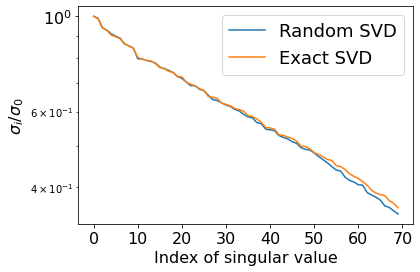

In [107]:
import numpy as np

n = 1000
k = 100
m = 200
# Lowrank matrix
A = np.random.randn(n, k)
B = np.random.randn(k, m)
A = A @ B

# Random matrix
# A = np.random.randn(n, m)

def randomized_svd(A, rank, p):
    m, n = A.shape
    G = np.random.randn(n, rank + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B)
    U = Q @ u
    return U, S, V

rank = 70
p = 20
U, S, V = randomized_svd(A, rank, p)
print("Error from randomized SVD", np.linalg.norm(A - U[:, :rank] * S[None, :rank] @ V[:rank, :]))
plt.semilogy(S[:rank] / S[0], label="Random SVD")
u, s, v = np.linalg.svd(A)
print("Error from exact SVD", np.linalg.norm(A - u[:, :rank] * s[None, :rank] @ v[:rank, :]))
plt.semilogy(s[:rank] / s[0], label="Exact SVD")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

In [111]:
import scipy.sparse.linalg as spsplin
# !pip install fbpca
# More details about Facebook package for computing randomized SVD is here: https://research.fb.com/blog/2014/09/fast-randomized-svd/ 
import fbpca
n = 1000
m = 200
A = np.random.randn(n, m)
k = 10
p = 10
%timeit spsplin.svds(A, k=k)
%timeit randomized_svd(A, k, p)
%timeit fbpca.pca(A, k=k, raw=False) 

9.47 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.65 ms ± 57.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.36 ms ± 81 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Covergence theorem

The averaged error of the presented algorithm, where $k$ is target rank and $p$ is oversampling parameter, is the following
- in Frobenius norm

$$ \mathbb{E}\|A - QQ^{\top}A \|_F \leq \left( 1 + \frac{k}{p-1} \right)^{1/2}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^2_j \right)^{1/2}  $$

- in spectral norm

$$ \mathbb{E}\|A - QQ^{\top}A \|_2 \leq \left( 1 + \sqrt{\frac{k}{p-1}} \right)\sigma_{k+1} + \frac{e\sqrt{k+p}}{p}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^2_j \right)^{1/2} $$

The expectation is taken w.r.t. random matrix $G$ generated in the method described above.

Compare these upper bounds with Eckart-Young theorem. Are these bounds good?



## Accuracy enhanced randomized SVD

- Main idea: power iteration
- If $A = U \Sigma V^\top$, then $A^{(q)} = (AA^{\top})^qA = U \Sigma^{2q+1}V^\top $, where $q$ some small natural number, e.g. 1 or 2
- Then we sample from $A^{(q)}$, not from $A$

$$ Y = (AA^{\top})^qAG \qquad Q, R = \mathtt{qr}(Y) $$

- The main reason: if singular values of $A$ decays slowly, the singular values of $A^{(q)}$ will decay faster 

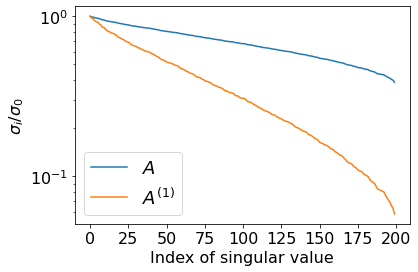

In [115]:
n = 1000
m = 200
A = np.random.randn(n, m)
s = np.linalg.svd(A, compute_uv=False)
Aq = A @ A.T @ A
sq = np.linalg.svd(Aq, compute_uv=False)
plt.semilogy(s / s[0], label="$A$")
plt.semilogy(sq / sq[0], label="$A^{(1)}$")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

### Loss of accuracy with rounding errors

- Compose $A^{(q)}$ naively leads to condition number grows and loss of accuracy

**Q:** how can we battle with this issue?

**A:** sequential orthogonalization!

Error from randomized SVD 286.78254212536973
Error from more accurate randomized SVD 250.30918436760263
Error from exact SVD 249.43968443603225


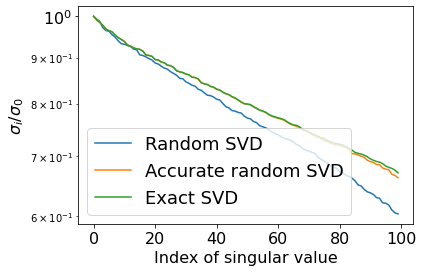

In [125]:
def more_accurate_randomized_svd(A, rank, p, q):
    m, n = A.shape
    G = np.random.randn(n, rank + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    for i in range(q):
        W = A.T @ Q
        W, _ = np.linalg.qr(W)
        Q = A @ W
        Q, _ = np.linalg.qr(Q)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B)
    U = Q @ u
    return U, S, V

n = 1000
m = 200
A = np.random.randn(n, m)

rank = 100
p = 20
U, S, V = randomized_svd(A, rank, p)
print("Error from randomized SVD", np.linalg.norm(A - U[:, :rank] * S[None, :rank] @ V[:rank, :]))
plt.semilogy(S[:rank] / S[0], label="Random SVD")

Uq, Sq, Vq = more_accurate_randomized_svd(A, rank, p, 5)
print("Error from more accurate randomized SVD", np.linalg.norm(A - Uq[:, :rank] * Sq[None, :rank] @ Vq[:rank, :]))
plt.semilogy(Sq[:rank] / Sq[0], label="Accurate random SVD")

u, s, v = np.linalg.svd(A)
print("Error from exact SVD", np.linalg.norm(A - u[:, :rank] * s[None, :rank] @ v[:rank, :]))
plt.semilogy(s[:rank] / s[0], label="Exact SVD")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

In [126]:
%timeit spsplin.svds(A, k=k)
%timeit fbpca.pca(A, k=k, raw=False)
%timeit randomized_svd(A, k, p) 
%timeit more_accurate_randomized_svd(A, k, p, 1)
%timeit more_accurate_randomized_svd(A, k, p, 2)
%timeit more_accurate_randomized_svd(A, k, p, 5)

9.05 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.4 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.17 ms ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.29 ms ± 97.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.23 ms ± 55.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.59 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Convergence theorem

The presented above method provides the following upper bound

$$ \mathbb{E}\|A - QQ^{\top}A \|_2 \leq \left[\left( 1 + \sqrt{\frac{k}{p-1}} \right)\sigma^{2q+1}_{k+1} + \frac{e\sqrt{k+p}}{p}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^{2(2q+1)}_j \right)^{1/2}\right]^{1/(2q+1)} $$

Consider the worst case, where no lowrank structure exists in the given matrix.

**Q:** what is the degree of suboptimality w.r.t. Eckart-Young theorem? 

### Summary on randomized SVD

- Efficient method to get approximate SVD
- Simple to implement
- It can be extended to one-pass method, where matrix $A$ is needed only to construct $Q$
- It requires only matvec with target matrix

## Kaczmarz method to solve linear systems 

- We have already discussed how to solve overdetermined linear systems $Ax = f$ in the least-squares manner
    - pseudoinverse matrix
    - QR decomposition
- One more approach is based on iterative projections a.k.a. **Kaczmarz method** or **algebraic reconstruction technique** in compoutational tomography domain
- Instead of solving all equations, pick one randomly, which reads

$$a^{\top}_i x = f_i,$$

and given an approximation $x_k$ try to find $x_{k+1}$ as 

$$x_{k+1} = \arg \min_x \frac12 \Vert x - x_k \Vert^2_2, \quad \mbox{s.t.} \quad  a^{\top}_i x = f_i.$$

- A simple analysis gives 

$$x_{k+1} = x_k - \frac{(a_i, x_k) - f_i}{(a_i, a_i)} a_i. $$

- A cheap update, but the analysis is quite complicated.
- You can recognize in this method stochastic gradient descent with specific step size equal to $\frac{1}{\|a_i\|_2^2}$ for every sample

## Convergence theorem

- Assume we generate $i$ according to the distribution over the all available indices proportional to norms of the rows, i.e. $\mathbb{P}[i = k] = \frac{\|a_k\|_2^2}{\| A \|^2_F}$. This method is called Randomized Kaczmarz method (RKM)
- Why sampling strategy is important here?
- Investigation of the best sampling is provided [here](https://scholar.harvard.edu/files/yuelu/files/randkac_globalsip14.pdf)
- If the overdetermined linear system is **consistent**, then

$$ \mathbb{E}[\|x_{k+1} - x^*\|^2_2] \leq \left(1 - \frac{1}{\kappa^2_F(A)}\right) \mathbb{E}[\|x_{k} - x^*\|^2_2], $$

where $\kappa_F(A) = \frac{\| A \|_F}{\sigma_{\min}(A)}$ and $\sigma_{\min}(A)$ is a minimal non-zero singular value of $A$. This result was presented in ([Strohmer and Vershynin, 2009](http://people.eecs.berkeley.edu/~brecht/cs294docs/week1/09.Strohmer.pdf))

- If the overdetermined linear system is **inconsistent**, then

$$ \mathbb{E}[\|x_{k+1} - x^*\|^2_2] \leq \left(1 - \frac{1}{\kappa^2_F(A)}\right) \mathbb{E}[\|x_{k} - x^*\|^2_2] + \frac{\|r^*\|_2^2}{\| A \|^2_F}, $$

where $r^* = Ax^* - f$

### Inconsistent overdetermined linear system

- It was shown in ([Needell, 2010](https://arxiv.org/pdf/0902.0958.pdf)) that RKM does not converge to $A^{\dagger}f$
- To address this issue Randomized extended Kaczmarz method was proposed in ([A Zouzias, N Freris, 2013](https://arxiv.org/pdf/1205.5770.pdf))
- The main idea is to use two steps of RKM:
    - the first step is for system $A^\top z = 0$ starting from $z_k$
    
    $$ z^{k+1} = z^{k} - \frac{a^\top_{:, j} z^k}{\| a_{:, j} \|_2^2}a_{:, j}  $$ 
    
    - the second step is for system $Ax = f - z_{k+1}$ starting from $x_k$
    
    $$x^{k+1} = x^k - \frac{a_{i,:}x_k - f_i + z^{k+1}_i}{\|a_{i,:}\|_2^2}a^{\top}_{i,:} $$
    
Here $a_{:, j}$ denotes the $j$-th column of $A$ and $a_{i, :}$ denotes the $i$-th row of $A$

- If $z^0 \in f + \mathrm{range}(A)$ and $x^0 \in \mathrm{range}(A^\top)$, then REK converegs exponentially to $A^{\dagger}f$ 

## Sampling and sketching

- Sampling of a particular row can be considered as a particular case of more general approach called **sketching**
- Idea: replace matrix $A$ with another matrix $SA$, where matrix $SA$ has significantly smaller number of rows but preserves some important properties of matrix $A$
- Possible choices:
    - random projection
    - random row selection
- Example: linear least squares problem $\|Ax - b\|_2^2 \to \min_x$ transforms to $\| (SA)y - Sb \|_2^2 \to \min_y$ and we expect that $x \approx y$
- [Blendenpick](https://pdos.csail.mit.edu/~petar/papers/blendenpik-v1.pdf) solver is based on that idea and outperforms LAPACK routine 
- More details see in [Sketching as a Tool for Numerical Linear Algebra](https://researcher.watson.ibm.com/researcher/files/us-dpwoodru/wNow3.pdf) by D. Woodruff

### Summary on randomized methods in solving linear systems

- Easy to use methods
- Especially useful in problems with streaming data
- Existing theoretical bounds for convergence
- Many interpretatiuons in different domains (SGD in deep learning, ART in computational tomography)

## Randomized matrix multiplication

- We know that matrix multiplication $AB$ costs $O(mnp)$ for matrices $m \times p$ and $p \times n$
- We can construct approximation of this product by sampling rows and columns of the multipliers

**Q:** how to sample them?

**A:** generate probabilities from their norms!

- So the final approximation expression

$$ AB \approx \sum_{t=1}^k \frac{1}{kp_{i_t}} A^{(i_t)} B_{(i_t)}, $$

where $A^{(i_t)}$ is a column of $A$ and $B_{(i_t)}$ is a row of $B$

- Complexity reduction from $O(mnp)$ to $O(mnk)$

In [174]:
import numpy as np

n = 20
p = 1000
m = 20
A = np.random.randn(n, p)
B = np.random.randn(p, m)
C = A @ B

def randomized_matmul(A, B, k):
    p = np.linalg.norm(A, axis=0) * np.linalg.norm(B, axis=1)
    p = p.ravel() / p.sum()
    n = A.shape[1]
    idx = np.random.choice(np.arange(n), (k,), False, p)
    d = 1 / np.sqrt(k * p[idx])
    A_sketched = A[:, idx] * d[None, :]
    B_sketched = B[idx, :] * d[:, None]
    C = A_sketched @ B_sketched
    return C

def randomized_matmul_topk(A, B, K):
    
    norm_mult = np.linalg.norm(A,axis=0) * np.linalg.norm(B,axis=1)
    top_k_idx = np.sort(np.argsort(norm_mult)[::-1][:K])
    
    A_top_k_cols = A[:, top_k_idx]
    B_top_k_rows = B[top_k_idx, :]

    C_approx = A_top_k_cols @ B_top_k_rows
    return C_approx

num_items = 300
C_appr_samples = randomized_matmul(A, B, num_items)
C_appr_topk = randomized_matmul_topk(A, B, num_items)
print(np.linalg.norm(C_appr_topk - C) / np.linalg.norm(C))
print(np.linalg.norm(C_appr_samples - C) / np.linalg.norm(C))

0.7514219112352372
1.496214137738649


## Approximation error

$$ \mathbb{E} [\|AB - CR\|^2_F] = \frac{1}{k} \left(\sum_{i=1}^n \| A^{(i)} \|_2 \| B_{(i)} \|_2\right)^2   - \frac{1}{k}\|AB\|_F^2 $$ 

- Other sampling probabilities are possible
- Use approximation
$$ AB \approx ASD(SD)^\top B  = ACC^{\top}B$$
can replace sampling and scaling with another matrix that
    
    - reduces the dimension
    - sufficiently accurately approximates

**Q:** what matrices can be used?

### Summary on randomized matmul

- Simple method to get approcimationoif result
- Can be used if the high accuracy is not crucial
- Especially useful for large dense matrices

## Take home message

- Matrix functions: matrix exponential, methods to compute matrix exponential
- Rational Krylov subspace
- Randomized SVD and other examples of randomized methods in NLA

## Plan for the next class

- Tensors
- Tensor decompositions
- Applications

In [21]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()